In [2]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
from utils import symbol_to_path, get_data, get_bollinger_bands, \
    daily_returns, cumulative_returns, plot_beta, plot_rolling, \
    normalize, plot_data

In [28]:
def get_cn_data(symbols, start, end):
    df = pd.DataFrame(index = [pd.date_range(start,end)])    
    for i, symbol in enumerate(symbols):    
        print '\nget_h_data', symbol
        df_tmp = ts.get_h_data(symbol,start=start, end=end)
        df_tmp = df_tmp.rename(columns={'close': symbol})        
        df1=pd.DataFrame(df_tmp.loc[:, symbol], columns=[symbol])
        df = df.join(df1)
        if i < 1:
            df=df.dropna()
    return df

df_cn = get_cn_data(symbols, '2017-01-13','2017-08-13')
df_cn.fillna(method='ffill', inplace=True)
df_cn = normalize(df_cn)
df_day = daily_returns(df_cn)


get_h_data 000001
[Getting data:]##
get_h_data 002542
[Getting data:]##
get_h_data 601992
[Getting data:]##

In [33]:
def gen_xy(df, Index):
    price = df['close'] # TBD use open, max, min -> average as price
    vol = df['volume']
    #tovr = df['turnoverratio']
    up, low = get_BB(price)
    df_day = daily_returns(df_sh01['close'])
    for i in range(20, len(Index)-N-1):
        missing =False
        for j in range(N+1):
            # filter by sh01 index  
            if Index[i+j] not in price:
                missing = True
                break
        if missing:
            continue
        xs, y = price.ix[Index[i]:Index[i+N]], price.ix[Index[i+N]]
        if xs.empty:
            continue
        yield gen_features(xs,y, df_day, up, low, i+N-1)
        #PE = 
        # TBD Y= y[0], y[5], y[20]

def gen_features(xs, y, df_day, up, low, i):
    mtm = momentum(xs)
    sma = SMA(xs)
    delta_up, delta_low = up[i], low[i]
    dfd = df_day.iloc[i]
    X = [mtm, sma, delta_up, delta_low, dfd]
    return X,y

def get_symbol_data(symbol, start, end):
    print '\nget_k_data', symbol
    #df = ts.get_k_data(symbol, start=start, end=end).set_index('date')[::-1]
    df = ts.get_h_data(symbol, start=start, end=end)[::-1]
    #df.fillna(method='ffill', inplace=True)
    df = normalize(df)
    for X,y in gen_xy(df, df_sh01.index):
        yield X,y

In [4]:
from utils import momentum, SMA, get_BB

symbols = ('002542', '601992')

N=5
sh01 = '000001'
start, end = '2017-01-13','2017-08-13'
df_sh01 = ts.get_h_data(sh01, start=start, end=end)[::-1] # ascend order
report = ts.get_report_data(2017,1)
report = report.set_index('code')

[Getting data:]##[Getting data:]#######################################################

In [35]:
# prepare data
Xs, ys=[], []
for symbol in symbols:
    for (X,y) in get_symbol_data(symbol, start, end):
        Xs.append(X)
        ys.append(y)


get_k_data 002542
[Getting data:]##
get_k_data 601992
[Getting data:]##[0.051359516616314105, -0.15245981490501714, 1.7167493433468635, 1.3086663336127593, -0.028959276018099556] 1.65320665083


In [54]:
from sklearn import linear_model
import numpy as np

# linear regression
Xs = np.array(Xs)
ys = np.array(ys)
# TODO shuffle
n_train = int(len(Xs) * 0.75)
clf = linear_model.LinearRegression()
clf.fit(Xs[:n_train], ys[:n_train])
print clf.coef_, clf.intercept_
#print clf.predict(2.5)

[ 0.54704363  0.94771683  0.59663372  0.27060515 -0.65827932] 0.286188998019


In [85]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=10, random_state=0)
regr.fit(Xs[:n_train], ys[:n_train])    
print(regr.feature_importances_)

[ 0.06698906  0.06494686  0.82397566  0.04053069  0.00355773]


In [86]:
# score
test = Xs[n_train:], ys[n_train:]
print 'score:',' lr:', clf.score(*test), 'rr:', regr.score(*test)
# show
for n in range(10):
    X, y = Xs[-n].reshape(1, -1), ys[-n]
    print y, 'lr:', clf.predict(X), 'rr:', regr.predict(X)

score:  lr: 0.657830398334 rr: -2.22740539554
1.10313315927 lr: [ 1.06425374] rr: [ 1.08851175]
1.65320665083 lr: [ 1.56726186] rr: [ 1.33890339]
1.6864608076 lr: [ 1.56218166] rr: [ 1.34112272]
1.63895486936 lr: [ 1.54342025] rr: [ 1.34112272]
1.6270783848 lr: [ 1.55860207] rr: [ 1.35665796]
1.57482185273 lr: [ 1.54433556] rr: [ 1.35704961]
1.57244655582 lr: [ 1.5227185] rr: [ 1.3573107]
1.5890736342 lr: [ 1.53436186] rr: [ 1.35678851]
1.56294536817 lr: [ 1.5425854] rr: [ 1.35718016]
1.44893111639 lr: [ 1.42765739] rr: [ 1.3535248]


In [ ]:
# TBD history PE, 市净率
#esp:每股收益, bvps:每股净资产
symbol
report.ix[symbol][['eps', 'bvps']]

In [284]:
df = ts.get_k_data(symbol, start=start, end=end).set_index('date')[::-1]

In [6]:
symbol = symbols[0]
df1 = ts.get_k_data(symbol, start=start, end=end)

-0.179790956427 0.00346588099477
0.11425416377 0.00406543695756


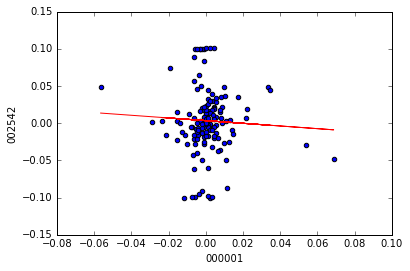

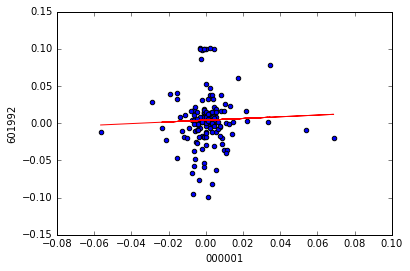

In [29]:
for symbol in symbols[1:]:
    plot_beta(df_day, symbols[0], symbol)
plt.show()

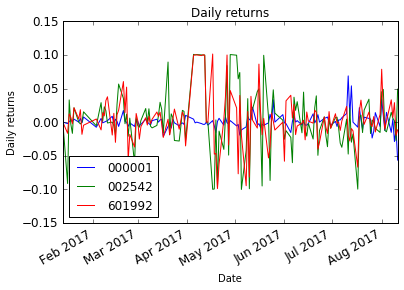

In [30]:
plot_data(df_day, title="Daily returns", ylabel="Daily returns")

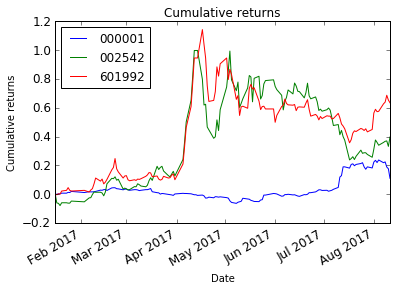

In [31]:
df_cum = cumulative_returns(df_cn)
plot_data(df_cum, title="Cumulative returns", ylabel="Cumulative returns")

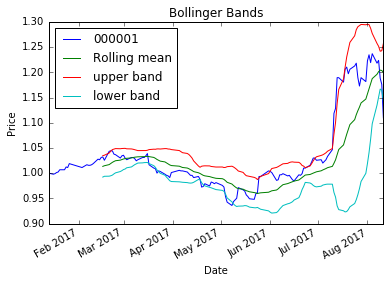

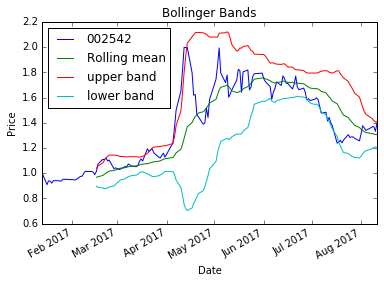

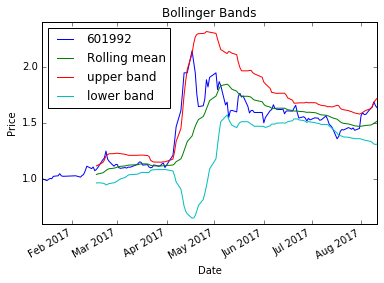

In [34]:
for symbol in symbols:
    plot_rolling(df_cn, symbol)